In [ ]:
# imports

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# TP5 Catégorisez automatiquement des questions

In this notebook we extract data from stackoverflow questions and perform an exploratory data analysis of the dataset.

The data can be originally found at: https://data.stackexchange.com/stackoverflow/query/new



**Questions we can ask:**
* Is all the text in english?
* Is the tagging correct (in other words, can we use it as ground truth?)
* What is the frequency of tags
* For a fixed tag, can we observe a pattern in the words used for writing the text or title?
* How do we map tags to tokens and tokens to tags?

# Problem definition:

In this exercise our objective is to suggest the tags for a stackoverflow question.

Ideally we should be able to decide a tag for the user based upon only the available input when creating a question, which is the Title and the Text.

Since the user that creates the question can input an arbitrary value we must chose to either restrict the problem or work with a loosened version.

In this series of notebooks we explore the possibility of solving tag suggestion by two approaches: in a supervised manner and unsuppervised.

The supervised case can be treated as a multiclass classification problem by restricting the number of tags to a fixed set and training a supervised method to generate a prediction.

To obtain tag suggestions based on an unsupervised approach we need to detect the patterns and clusters present in different representation spaces of our data and depending on the way the method is applied. To achieve this, further process the data is needed to obtain a prediction.

Having established our goals, our exploratory analisys **must** verify the feasibility of treating the problem as a multiclass classification problem, explore the distribution of data such that we avoid unwated biases, analyse the need for preprocessing, and more generally study the complexity of the dataset and the computational limits imposed on the methods we will employ given the available resources.


# First exploration: 50k posts containining Title, tags and text

We download two sets of size 50K sampled randomly from the dataset.

We also download the set of the top 1000 tags.

The dataset also contains all the used Tags and their overall counts:

In [ ]:
# downlaod and unzip tags counts
from google_drive_downloader import GoogleDriveDownloader as gdd

files = ['1xOY-DGZZitqMQMS9CpE6lrSY4_8rvQ_g', '1aGnT5OqAN7KmJoyEiWnFsnCELVun7s-s']

for file in files:
  data_path = os.path.join('.','data')

  gdd.download_file_from_google_drive(file_id=file,
                                      dest_path=data_path,
                                      unzip=True)
  # remove .zip data
  os.system('rm -rf data')

Unzipping...Done.
Unzipping...Done.


# 1. Exploratory analysis:

First we perform a visual check of the columns of the dataset. It corresponds with the columns that were downloaded using our SQL program. It contains all the relevant information needed to perform the tag inference problem as defined in the introduction of the notebook. Finally, all of the fields are present because we set it as a condition in the SQL program.

In [ ]:
df = pd.read_csv('PostSample_1.csv')

In [ ]:
df

,Id,Body,Title,Tags,CreationDate,Score
0,1829,<p>I've got a menu in Python. That part was ea...,How do I make a menu that does not require the...,<python>,2008-08-05 02:39:23,27
1,3448,"<p>I've noticed a lot of sites, SO included, u...",Is it acceptable for invalid XHTML?,<xhtml><markup>,2008-08-06 14:21:18,21
2,8214,<p>How are you instrumenting your UI's? In the...,Instrumenting a UI,<wpf><user-interface><instrumentation>,2008-08-11 21:00:40,8
3,10919,<p>Usually when I'm creating indexes on tables...,How do you measure SQL Fill Factor value,<sql-server><fillfactor>,2008-08-14 12:07:27,8
4,11127,"<p>In a C++ Windows (XP and NT, if it makes a ...",In C++/Windows how do I get the network name o...,<c++><windows-xp><networking><windows-nt>,2008-08-14 14:37:27,8
...,...,...,...,...,...,...
49995,72158461,<p>I have selected rows from a table<br />\nta...,how to move to the top an array element,<php><arrays><unset>,2022-05-08 05:50:29,1
49996,72160294,<p>This code that worked perfectly on these fo...,CefSharp WinForms 101 read the cookies from br...,<c#><cefsharp>,2022-05-08 10:56:30,1
49997,72160981,"<p>I there,\nI have a text file like this:</p>...",How to make a line by line text in to a csv file,<python><r><bash><awk><sed>,2022-05-08 12:28:41,1
49998,72168223,<p>I have Java Maven project with com.github.d...,How can I execute predefined docker command fr...,<java><docker><docker-api>,2022-05-09 07:15:35,2


In [ ]:
df.head(10)

,Id,Body,Title,Tags,CreationDate,Score
0,1829,<p>I've got a menu in Python. That part was ea...,How do I make a menu that does not require the...,<python>,2008-08-05 02:39:23,27
1,3448,"<p>I've noticed a lot of sites, SO included, u...",Is it acceptable for invalid XHTML?,<xhtml><markup>,2008-08-06 14:21:18,21
2,8214,<p>How are you instrumenting your UI's? In the...,Instrumenting a UI,<wpf><user-interface><instrumentation>,2008-08-11 21:00:40,8
3,10919,<p>Usually when I'm creating indexes on tables...,How do you measure SQL Fill Factor value,<sql-server><fillfactor>,2008-08-14 12:07:27,8
4,11127,"<p>In a C++ Windows (XP and NT, if it makes a ...",In C++/Windows how do I get the network name o...,<c++><windows-xp><networking><windows-nt>,2008-08-14 14:37:27,8
5,13396,"<p>I love list comprehensions in Python, becau...",Replacement for for... if array iteration,<.net><python><arrays><loops><iteration>,2008-08-16 22:28:39,12
6,18298,<p>I cannot figure out how to change the title...,How do I change the title bar icon in Adobe AIR?,<apache-flex><air>,2008-08-20 16:15:55,1
7,19604,<p>What is the best Image Manager to integrate...,Best TinyMce editor Image Manager / File uploa...,<asp.net><asp.net-mvc><.net-2.0>,2008-08-21 10:53:54,28
8,20034,"<p><a href=""http://en.wikipedia.org/wiki/Proje...",Is Project Darkstar Realistic?,<java><concurrency><distributed>,2008-08-21 14:13:11,26
9,20386,<p>What are all the possible ways in which we ...,Memory leaks in .NET,<.net><optimization><memory-leaks>,2008-08-21 16:11:34,20


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.dtypes

Id               int64
Body            object
Title           object
Tags            object
CreationDate    object
Score            int64
dtype: object

## 1. Tag analysis

Tags are written between less-than and greather-than signs on a single string.To work with individual tags we first have to process them using regex and create a list of tags that can be manipulated.

In [ ]:
# separate tags into a list of tags using a lambda function
get_tags = lambda x: re.findall("\<(.*?)\>", x)

df['Tags'] = df['Tags'].apply(get_tags)

df.head()


,Id,Body,Title,Tags,CreationDate,Score
0,1829,<p>I've got a menu in Python. That part was ea...,How do I make a menu that does not require the...,[python],2008-08-05 02:39:23,27
1,3448,"<p>I've noticed a lot of sites, SO included, u...",Is it acceptable for invalid XHTML?,"[xhtml, markup]",2008-08-06 14:21:18,21
2,8214,<p>How are you instrumenting your UI's? In the...,Instrumenting a UI,"[wpf, user-interface, instrumentation]",2008-08-11 21:00:40,8
3,10919,<p>Usually when I'm creating indexes on tables...,How do you measure SQL Fill Factor value,"[sql-server, fillfactor]",2008-08-14 12:07:27,8
4,11127,"<p>In a C++ Windows (XP and NT, if it makes a ...",In C++/Windows how do I get the network name o...,"[c++, windows-xp, networking, windows-nt]",2008-08-14 14:37:27,8


### 1.1 Tag histogram

An important statistic that we can extract from our dataset is the tag frequency on our dataset.

#### Stack overflow full tag data of top 50k occuring tags

In [ ]:
df_tags = pd.read_csv('TopTags.csv')
df_tags.head()

,Id,TagName,Count
0,3,javascript,2387264
1,16,python,1968760
2,17,java,1850627
3,9,c#,1543059
4,5,php,1438539


We can check the appearence of specific tags

In [ ]:
df_tags.loc[df_tags.TagName == 'matlab']

,Id,TagName,Count
81,854,matlab,93022


In [ ]:
len(df_tags)

50000

Check if there are null values:

In [ ]:
df_tags.isnull().values.any()

True

Let's see where

In [ ]:
df_tags[df_tags.isna().any(axis=1)]

,Id,TagName,Count
553,694,NaN,15462
1819,9745,NaN,3930


**WARNING!!!**

**We verify in the .csv that line 553 actually corresponds with the tag 'null' and that 1819 corresponds to the tag 'nan'. This has to be fixed by hand.**

In [ ]:
df_tags.at[553, 'TagName'] = 'null'
df_tags.at[1819, 'TagName'] = 'nan'


We observe that if we set a minimal number of tag appearence, the tag space is greatly reduced.

In [ ]:
# we will use the tag array to check for tag matches
full_tags_array = (df_tags.TagName).to_numpy()

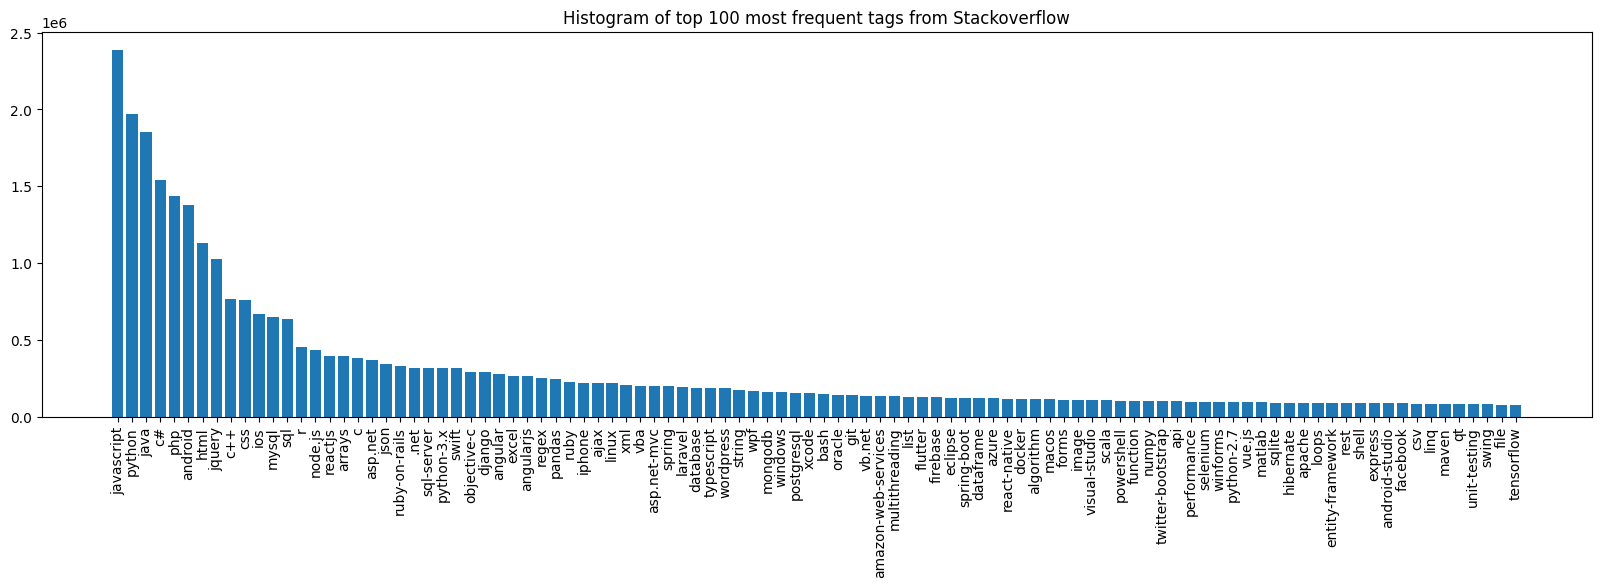

In [ ]:
# display histogram of full tag frequency dataset
n_tags = 100
plt.figure(figsize = (20, 5))
plt.bar((df_tags.TagName).to_numpy()[:n_tags],(df_tags.Count).to_numpy()[:n_tags])
plt.xticks(rotation = 'vertical')
plt.title(('Histogram of top {} most frequent tags from Stackoverflow').format(n_tags))
plt.show()

#### We can also use the full tag data to select an interval of tags that contains most of the data

We observe that the data is very unequaly distributed measuring approximately:

* 14 of tags represent 25% of total tags
* 138 of tags represent 50% of total tags
* 1071 of tags represent 75% of total tags
* 4691 of tags represent 90% of total tags
* 9662 of tags represent 95% of total tags
* 18537 of tags represent 98% of total tags
* 25850 of tags represent 99% of total tags

In [ ]:
full_tag_count = (df_tags.Count).to_numpy()
total = sum(full_tag_count)

percentages = [0.25,0.5,0.75,0.9,0.95,0.98,0.99]
pct_id = 0
cumsum = 0
for i, val in enumerate(full_tag_count):
  cumsum += val
  if cumsum/total >= percentages[pct_id]:
    print('{:.2f}% of tags represent {}% of total tags'.format(i/len(full_tag_count)*100 ,percentages[pct_id]*100))
    if pct_id < len(percentages) - 1:
      pct_id += 1
    else:
      break



0.03% of tags represent 25.0% of total tags
0.28% of tags represent 50.0% of total tags
2.14% of tags represent 75.0% of total tags
9.38% of tags represent 90.0% of total tags
19.32% of tags represent 95.0% of total tags
37.07% of tags represent 98.0% of total tags
51.70% of tags represent 99.0% of total tags


## Validating our dataset of 50 k sampled questions:

Since the total dataset size is gigantic we need to have a method of detecting if the sampling of the dataset reflects the total dataset statistics.
For instance, sampling the dataset on a specific timeframe can lead to a different histogram where a tag is not present.

We can compare statistics of tag frequency from the full dataset and from our subset of tags.

### 1. Statistics using subset 50k sampled Questions

In [ ]:
df['Tags']

0                                         [python]
1                                  [xhtml, markup]
2           [wpf, user-interface, instrumentation]
3                         [sql-server, fillfactor]
4        [c++, windows-xp, networking, windows-nt]
                           ...                    
49995                         [php, arrays, unset]
49996                               [c#, cefsharp]
49997                  [python, r, bash, awk, sed]
49998                   [java, docker, docker-api]
49999                                        [sql]
Name: Tags, Length: 50000, dtype: object

In [ ]:
sampled_tag_array = df['Tags'].to_numpy()

Lets apply the some of the same techniques to see if the statistics are the same as the ones from the full tag dataset.

First we create a dict of the observed tags to count them.

In [ ]:
sampled_tag_array[0]

['python']

In [ ]:
# create tag dict to count unique tag occurences
tag_dict = {}
for tag_list in sampled_tag_array:
  for tag in tag_list:
    if tag in tag_dict:
      tag_dict[tag] += 1
    else:
      tag_dict[tag] = 1

In [ ]:
tag_dict = dict(sorted(tag_dict.items(), key=lambda item: item[1], reverse = True))

In [ ]:
tag_dict

{'javascript': 4817,
 'python': 4420,
 'java': 4068,
 'c#': 3540,
 'android': 3076,
 'php': 2634,
 'html': 2135,
 'jquery': 1954,
 'c++': 1891,
 'ios': 1611,
 'css': 1470,
 'sql': 1209,
 'r': 1149,
 'mysql': 1111,
 'node.js': 956,
 'c': 862,
 '.net': 861,
 'reactjs': 834,
 'ruby-on-rails': 810,
 'arrays': 712,
 'asp.net': 712,
 'swift': 695,
 'objective-c': 691,
 'json': 677,
 'sql-server': 662,
 'django': 631,
 'python-3.x': 612,
 'angularjs': 601,
 'pandas': 592,
 'iphone': 588,
 'regex': 573,
 'angular': 565,
 'linux': 529,
 'ruby': 528,
 'spring': 468,
 'excel': 456,
 'xml': 446,
 'asp.net-mvc': 440,
 'git': 406,
 'windows': 381,
 'typescript': 379,
 'wpf': 378,
 'ajax': 376,
 'xcode': 370,
 'laravel': 366,
 'string': 359,
 'mongodb': 353,
 'database': 352,
 'vba': 351,
 'multithreading': 345,
 'scala': 345,
 'amazon-web-services': 334,
 'postgresql': 327,
 'eclipse': 306,
 'bash': 304,
 'macos': 292,
 'docker': 288,
 'visual-studio': 287,
 'flutter': 284,
 'performance': 279,
 'wo

In [ ]:
sampled_tag_cunt = list(tag_dict.values())

total = sum(sampled_tag_cunt)

percentages = [0.25,0.5,0.75,0.9,0.95,0.98,0.99]
pct_id = 0
cumsum = 0
for i, val in enumerate(sampled_tag_cunt):
  cumsum += val
  if cumsum/total >= percentages[pct_id]:
    print('{:.2f}% of tags represent {}% of total tags'.format(i/len(sampled_tag_cunt)*100 ,percentages[pct_id]*100))

    if pct_id < len(percentages) - 1:
      pct_id += 1
    else:
      break

0.11% of tags represent 25.0% of total tags
1.09% of tags represent 50.0% of total tags
7.81% of tags represent 75.0% of total tags
29.99% of tags represent 90.0% of total tags
51.68% of tags represent 95.0% of total tags
80.18% of tags represent 98.0% of total tags
90.09% of tags represent 99.0% of total tags


Now let's look at the histogram of the 100 most frequent tags

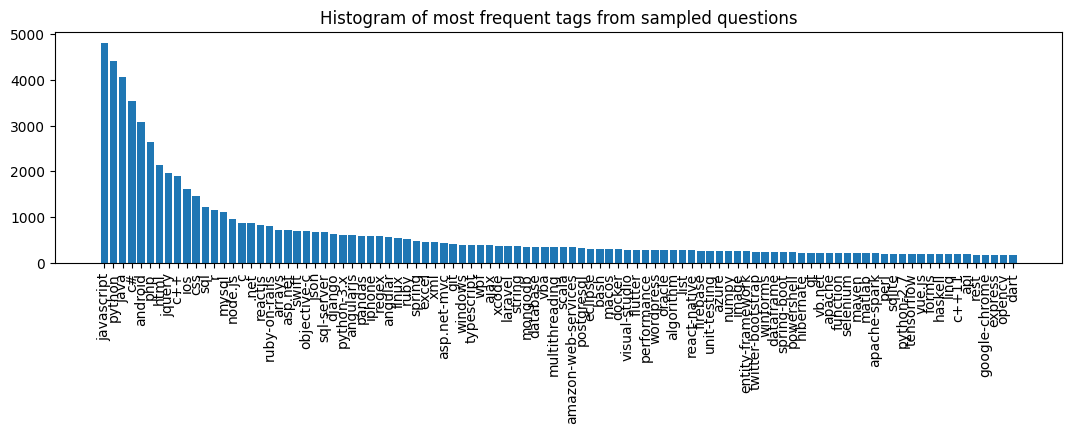

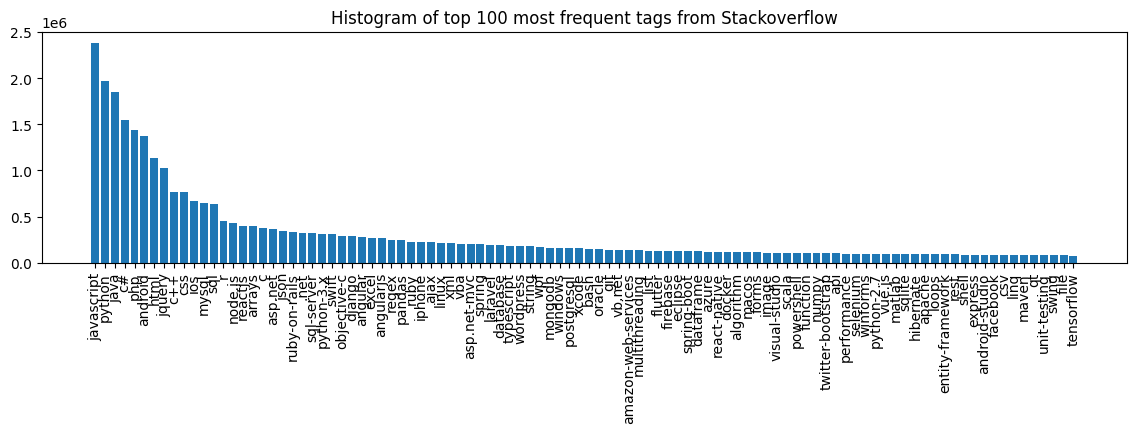

In [ ]:
# display histogram of 100 most frequent tags from sampled questions
n_tags = 100

plt.figure(figsize = (13, 3))
plt.bar(list(tag_dict.keys())[:n_tags],list(tag_dict.values())[:n_tags])
plt.xticks(rotation = 'vertical')
plt.title('Histogram of most frequent tags from sampled questions')
plt.show()

# display histogram of full tag frequency dataset
n_tags = 100
plt.figure(figsize = (14, 3))
plt.bar((df_tags.TagName).to_numpy()[:n_tags],(df_tags.Count).to_numpy()[:n_tags])
plt.xticks(rotation = 'vertical')
plt.title(('Histogram of top {} most frequent tags from Stackoverflow').format(n_tags))
plt.show()

Now let's look at the histogram of the 100 less frequent tags

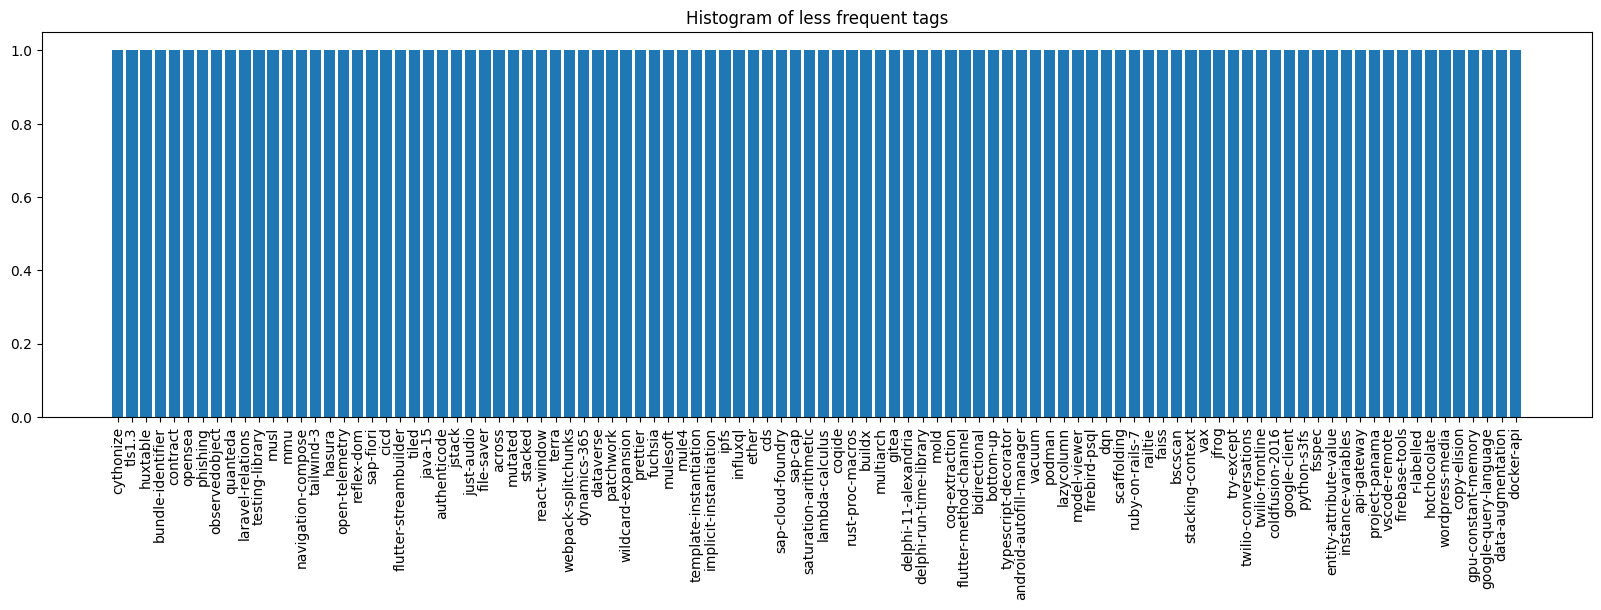

In [ ]:
n_tags = 100
plt.figure(figsize = (20, 5))
plt.bar(list(tag_dict.keys())[-n_tags:],list(tag_dict.values())[-n_tags:])
plt.xticks(rotation = 'vertical')
plt.title('Histogram of less frequent tags')
plt.show()

We can observe that that the distribution of tags is unequal: some tags are much more represented than others. The following plot contains the histogram of all sampled tags.

[]

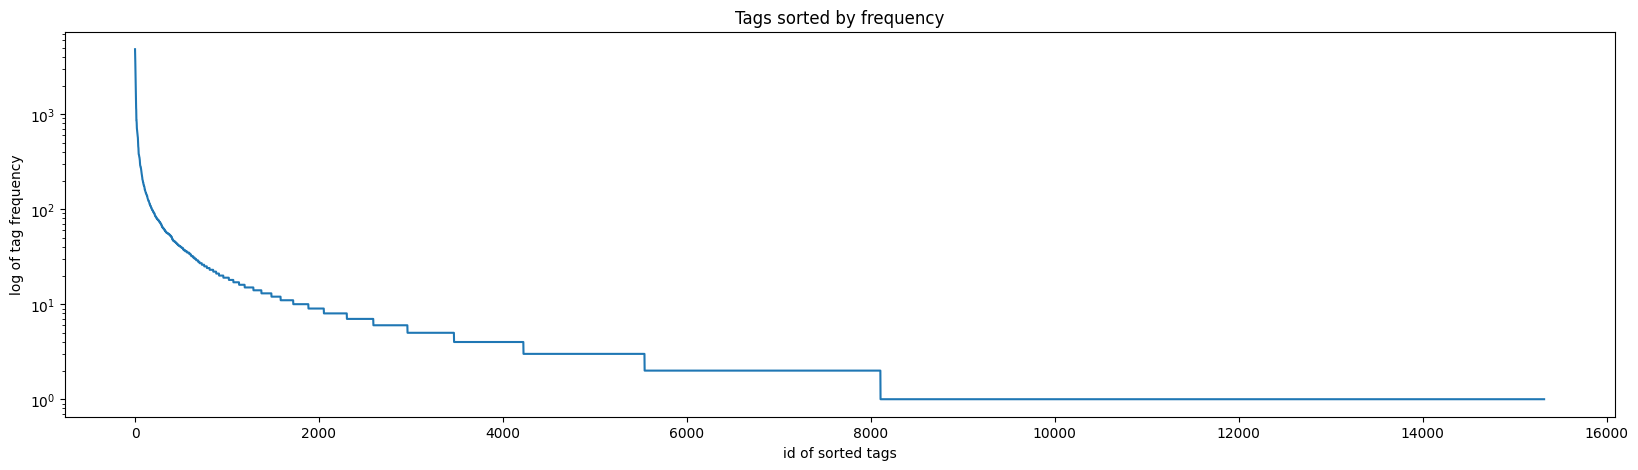

In [ ]:
fig = plt.figure(figsize = (20, 5))
ax = fig.add_subplot()
ax.plot(range(len(tag_dict)), list(tag_dict.values()))
ax.set_yscale('log')
ax.set_title('Tags sorted by frequency')
ax.set_xlabel('id of sorted tags')
ax.set_ylabel('log of tag frequency')
plt.plot()

**Conclusion:** We can visually and numerically observe that the sampled data do not differ much from the total stackoverflow statistics.  

### 1.2 Tags per question

Now we plot the number of tags per question and check for the presence of questions without tags. We observe that there are no questions with more than 5 tags.

In [ ]:
sampled_tag_array

array([list(['python']), list(['xhtml', 'markup']),
       list(['wpf', 'user-interface', 'instrumentation']), ...,
       list(['python', 'r', 'bash', 'awk', 'sed']),
       list(['java', 'docker', 'docker-api']), list(['sql'])],
      dtype=object)

In [ ]:
# check if there is a question with more than 5 tags
for tags in sampled_tag_array:
   if len(tags) > 5:
     print('higher than 5')

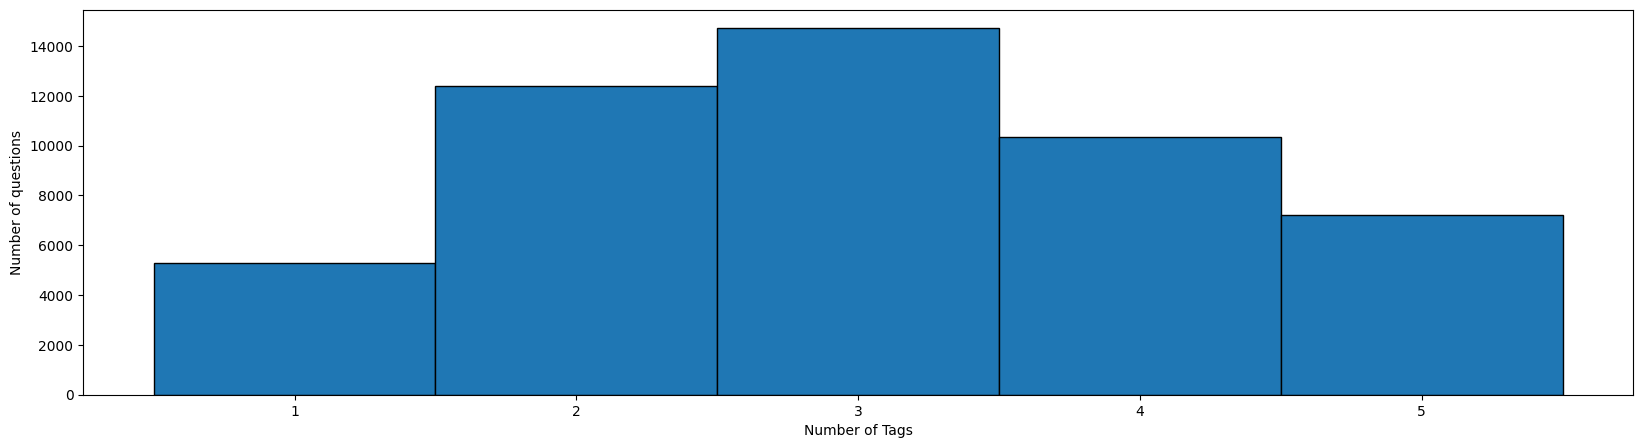

In [ ]:
plt.figure(figsize = (20, 5))
plt.hist([len(tags) for tags in sampled_tag_array],  bins=np.arange(0,6)+0.5, ec="k")
plt.ylabel('Number of questions')
plt.xlabel('Number of Tags')
plt.show()

### 1.3 Tags timeline

Here we analyse the evolution of tag frequency on our dataset according to their timestamp. For instance, as programming languages popularities are dynamic, we should observe a increase or decrease according to each year usage among programmers.

In [ ]:
# set number of top tags to analyse
n = 10
top_n = [tag for idx, tag in enumerate(tag_dict) if idx < n]

# lambda function to extract year given standard dataset format and a specific tag
get_year = lambda df, name: [date[:4] for date in df[[name in tags for tags in df.Tags]].CreationDate.to_numpy()]

# list containing dicts of tag occurence per year
tags_to_year = []
for tag in top_n:
  tags_to_year.append(Counter(get_year(df, tag)))

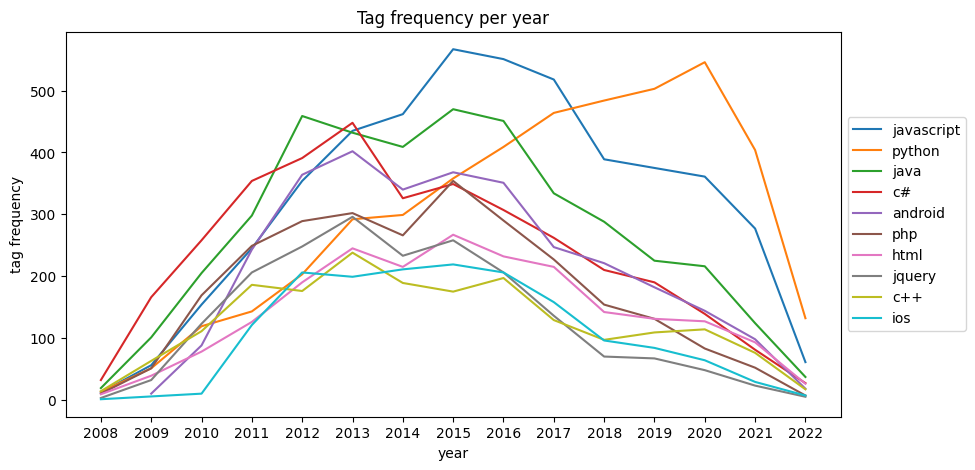

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()
for idx, tag in enumerate(top_n):
  ax.plot(list(tags_to_year[idx].keys()), list(tags_to_year[idx].values()))
ax.set_title('Tag frequency per year')
ax.set_xlabel('year')
ax.set_ylabel('tag frequency')
ax.legend(top_n , bbox_to_anchor=(1.0,0.5) , loc="center left")

fig.show()

Simply counting the number of tags used on each year can be misleading since the total number of tags can increase but the relative proportion of a tag can decrease. Note that for the current year 2022 the number of questions is still increasing and as such the drop in the graph does not mean the usage is decreasing!

Normalizing the tag count by the total number of questions (note that a tag can appear on multiple questions) on each year offers the visualization of the popularity of a tag on a given year.

In [ ]:
# get questions count for each year
annual_question_count = Counter([date[:4] for date in df.CreationDate.to_numpy()])

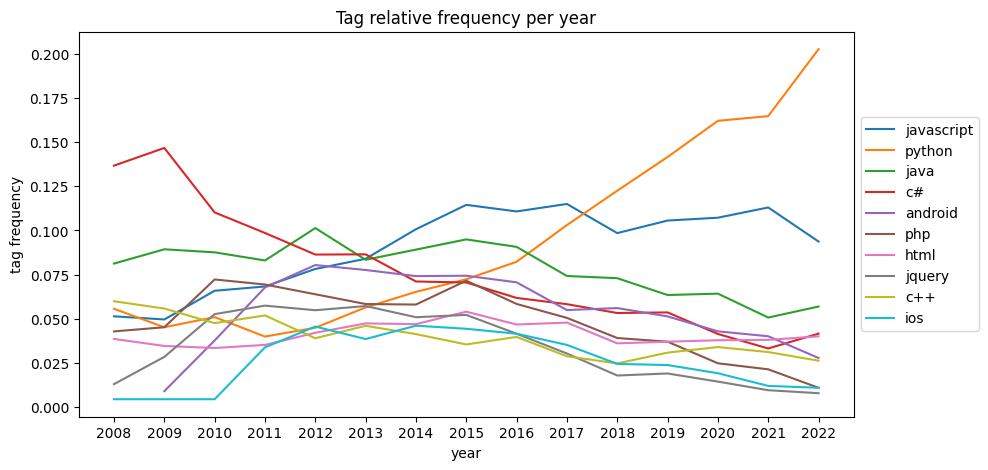

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()
for idx, tag in enumerate(top_n):
  year_list = list(tags_to_year[idx].keys())
  val_list = list(tags_to_year[idx].values())
  values = [val/annual_question_count[year] for val, year in zip(val_list, year_list)]
  ax.plot(list(tags_to_year[idx].keys()), values)
ax.set_title('Tag relative frequency per year')
ax.set_xlabel('year')
ax.set_ylabel('tag frequency')
ax.legend(top_n , bbox_to_anchor=(1.0,0.5) , loc="center left")

fig.show()

Interestingly now we can see that although some tags increased their appearence over a year they actually decreased in popularity in the following year.

**Another idea... tags timeline for discovering trends**

The timeline above seems to show that python is increasing in use while the rest is loosing users. Another interesting visualization is that of the languages that have had more growth over all of the tags. We could use the tag variation over the years and select those that increases the most. We leave this experiment as a task for the future.

### 1.4 Question score

One of the attributes of the dataset is the question score, which is defined as the difference between upvotes and downvotes of a question. It is interesting to observe if the observations already done change significantly when we take into account questions that have a positive score higher than a threshold value.



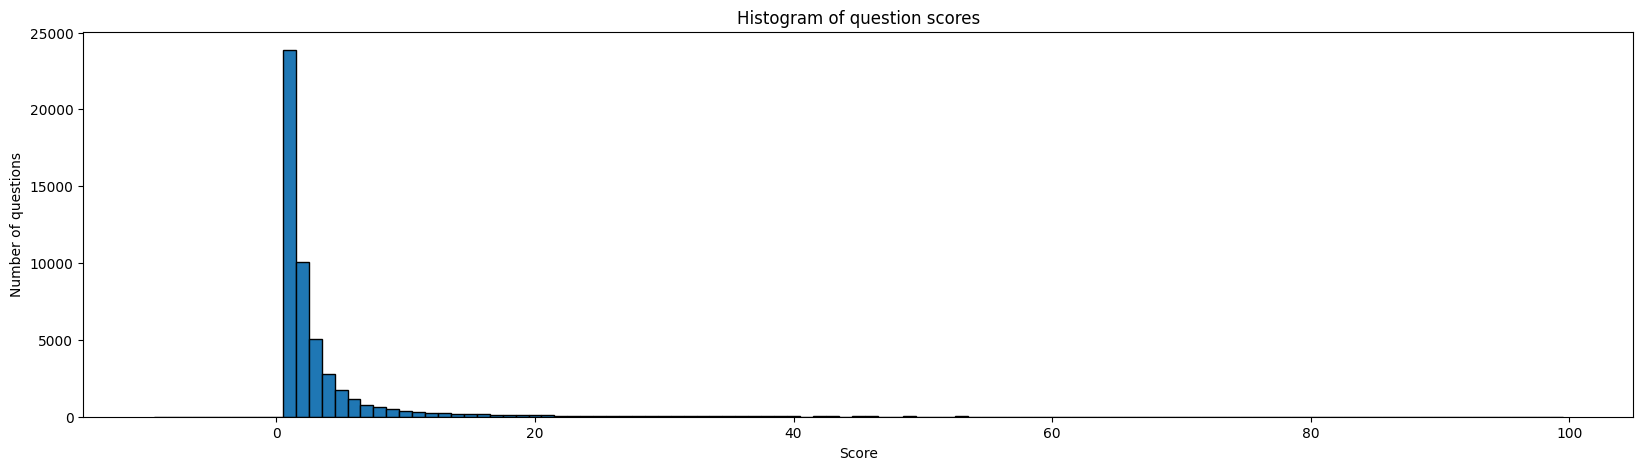

In [ ]:
score_array = df['Score'].to_numpy()
plt.figure(figsize = (20, 5))
plt.hist(score_array,  bins=np.arange(-10,100)+0.5, ec="k")
plt.xticks(rotation = 'horizontal')
plt.title('Histogram of question scores')
plt.ylabel('Number of questions')
plt.xlabel('Score')
plt.show()

We observe that most of the questions have a score greater than zero. Questions that have score zero tend are the most common and scores lower than zero do not tend to be present.

In the cells below we run some of the exploratory scripts again to observe the influence of the score over data.

In [ ]:
def score_threshold_tag_resutlts(tr_score = 1):
  # set threshold for score
  tag_array_a = df[df.Score >= tr_score]['Tags'].to_numpy()
  tag_array_b = df[df.Score < tr_score]['Tags'].to_numpy()
  ntags_a = len(df[df.Score >= tr_score])
  ntags_b = len(df[df.Score < tr_score])

  print("There are {} questions with score greater or equal than {}".format(ntags_a, tr_score))
  print("There are {} questions with score less or equal than {}".format(ntags_b, tr_score))
  tag_dict_a = {}
  for tag_list in tag_array_a:
    for tag in tag_list:
      if tag in tag_dict_a:
        tag_dict_a[tag] += 1
      else:
        tag_dict_a[tag] = 1

  tag_dict_b = {}
  for tag_list in tag_array_b:
    for tag in tag_list:
      if tag in tag_dict_b:
        tag_dict_b[tag] += 1
      else:
        tag_dict_b[tag] = 1

  tag_dict_a = dict(sorted(tag_dict_a.items(), key=lambda item: item[1], reverse = True))
  tag_dict_b = dict(sorted(tag_dict_b.items(), key=lambda item: item[1], reverse = True))
  n_tags = 50
  fig, axs = plt.subplots(1, 2,figsize = (20,5))
  axs[0].bar(list(tag_dict_a.keys())[:n_tags],list(tag_dict_a.values())[:n_tags])
  axs[0].title.set_text('Tag histogram of questions with score greater or equal than {}'.format(tr_score))

  axs[1].bar(list(tag_dict_b.keys())[:n_tags],list(tag_dict_b.values())[:n_tags], color='orange')
  axs[1].title.set_text('Tag histogram of questions with score less than {}'.format(tr_score))



  for ax in fig.axes:
      plt.sca(ax)
      plt.xticks(rotation=90)

  plt.show()
  fig, axs = plt.subplots(1, 2,figsize = (20,5))
  axs[0].hist([len(tags) for tags in tag_array_a],  bins=np.arange(0,6)+0.5, ec="k")
  axs[0].title.set_text('Number of questions with score greater or equal than {}'.format(tr_score))
  axs[0].set_xlabel('Number of Tags')
  axs[0].set_ylabel('Number of Questions')


  axs[1].hist([len(tags) for tags in tag_array_b],  bins=np.arange(0,6)+0.5, ec="k", color='orange')
  axs[1].title.set_text('Number tags per questions with score less than {}'.format(tr_score))
  axs[1].set_xlabel('Number of Tags')
  axs[1].set_ylabel('Number of Questions')

  plt.show()

Here we observe the histogram of questions given scores greater than and less than 5.

There are 8235 questions with score greater or equal than 5
There are 41765 questions with score less or equal than 5


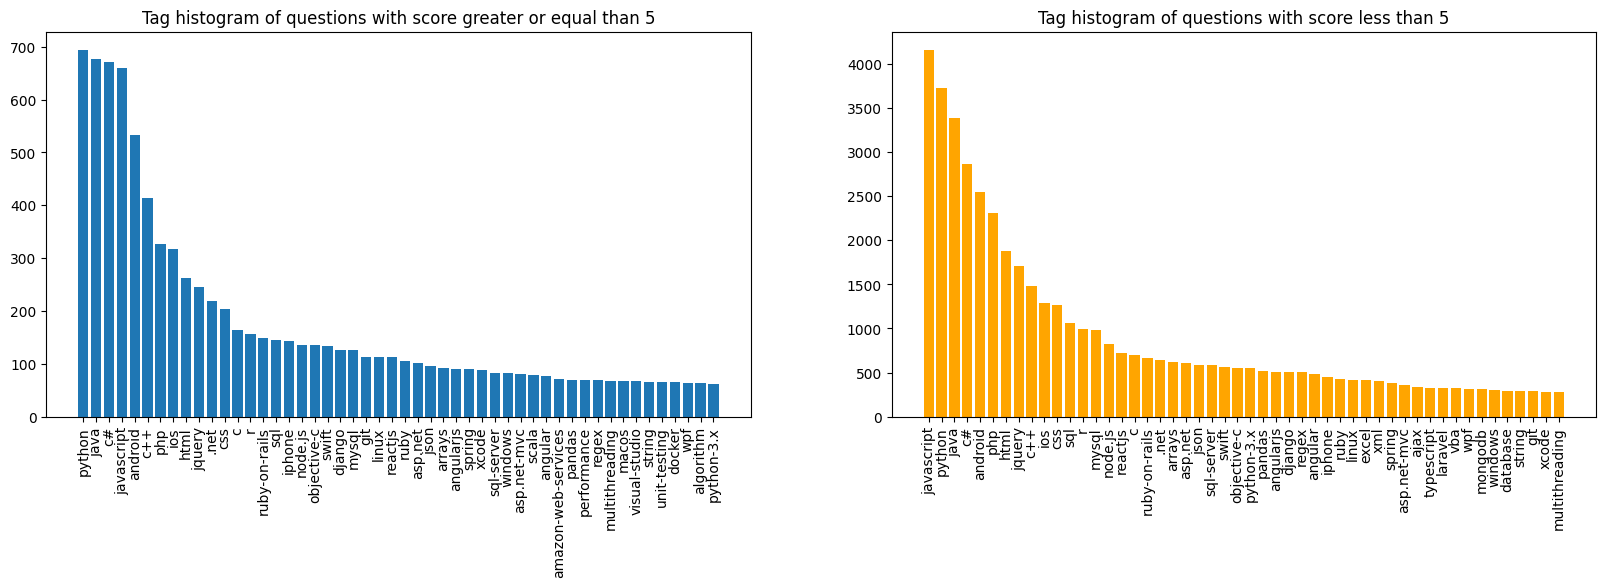

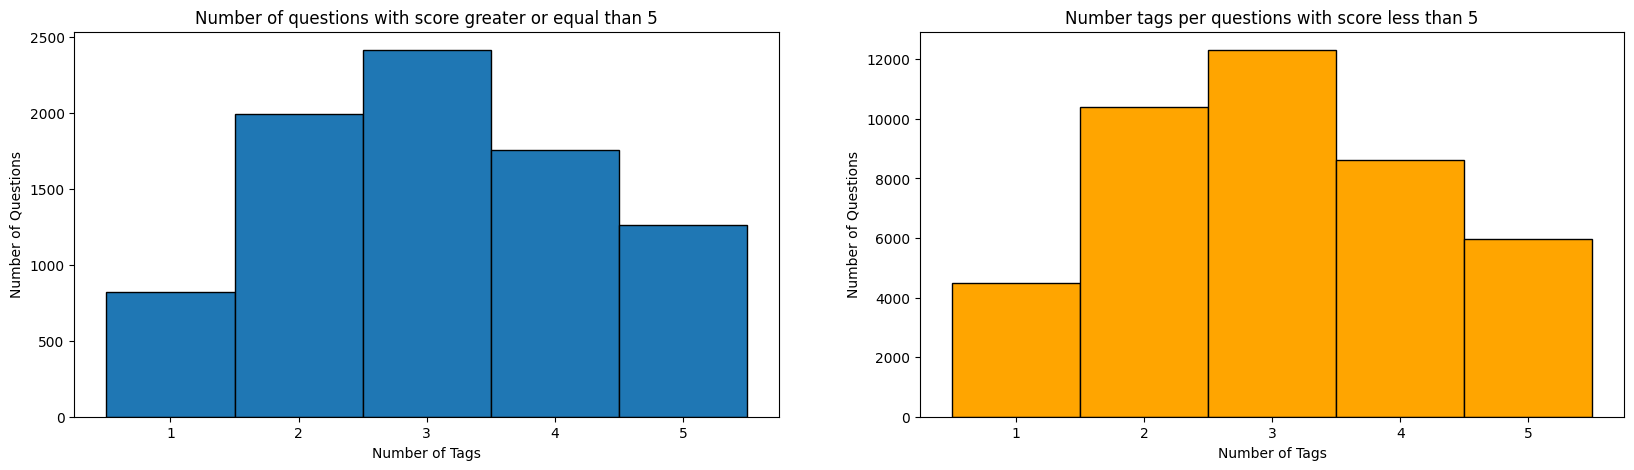

In [ ]:
score_threshold_tag_resutlts(5)

And here greater than 10

There are 3491 questions with score greater or equal than 10
There are 46509 questions with score less or equal than 10


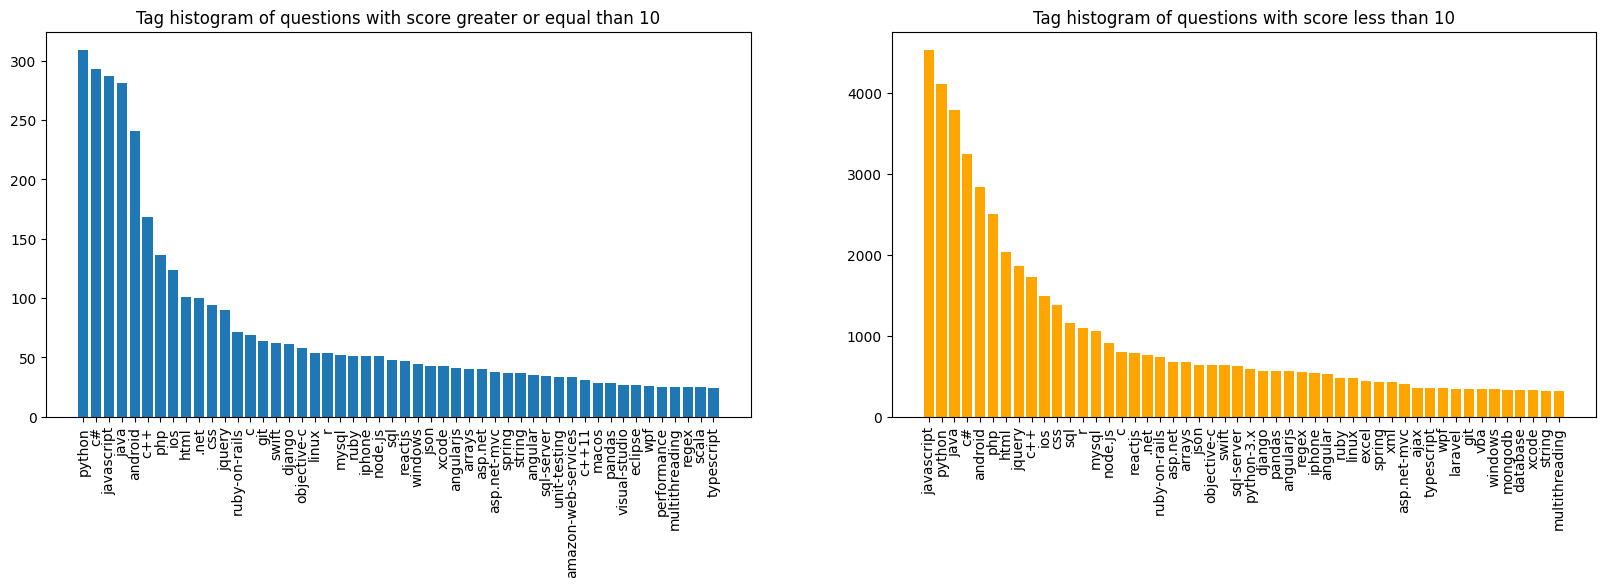

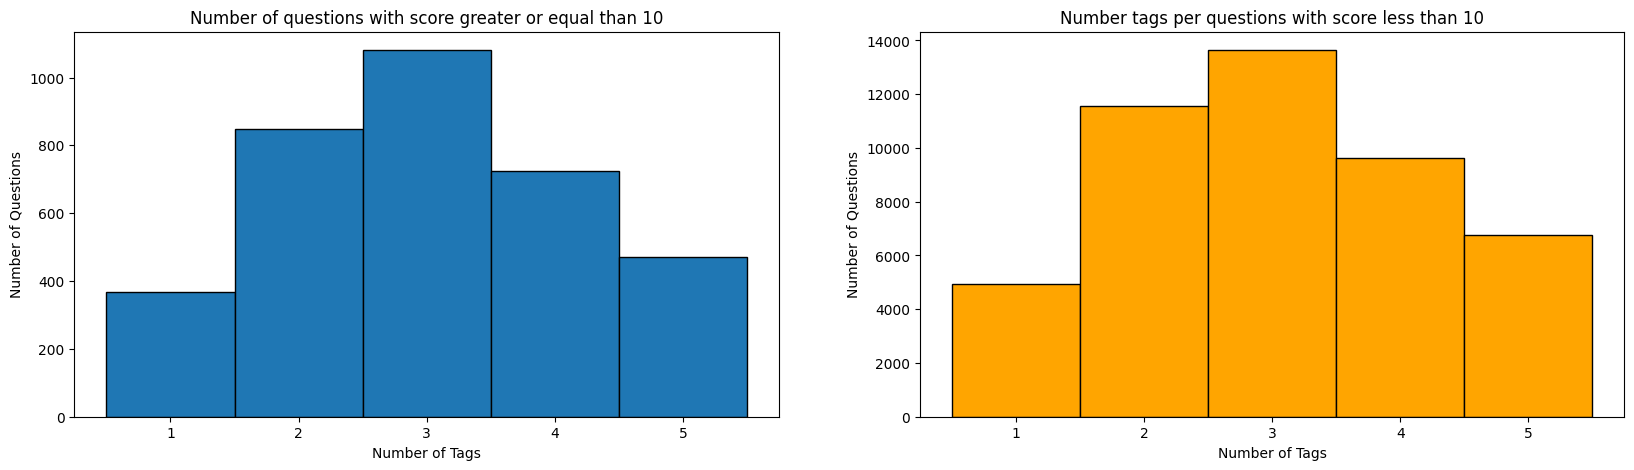

In [ ]:
score_threshold_tag_resutlts(10)

And greater than 20.

**Observation** Here we observe that C# becomes the most common tag. This implies that sampling the dataset selecting those that have high score produces a a biase in the sampling.

There are 1560 questions with score greater or equal than 20
There are 48440 questions with score less or equal than 20


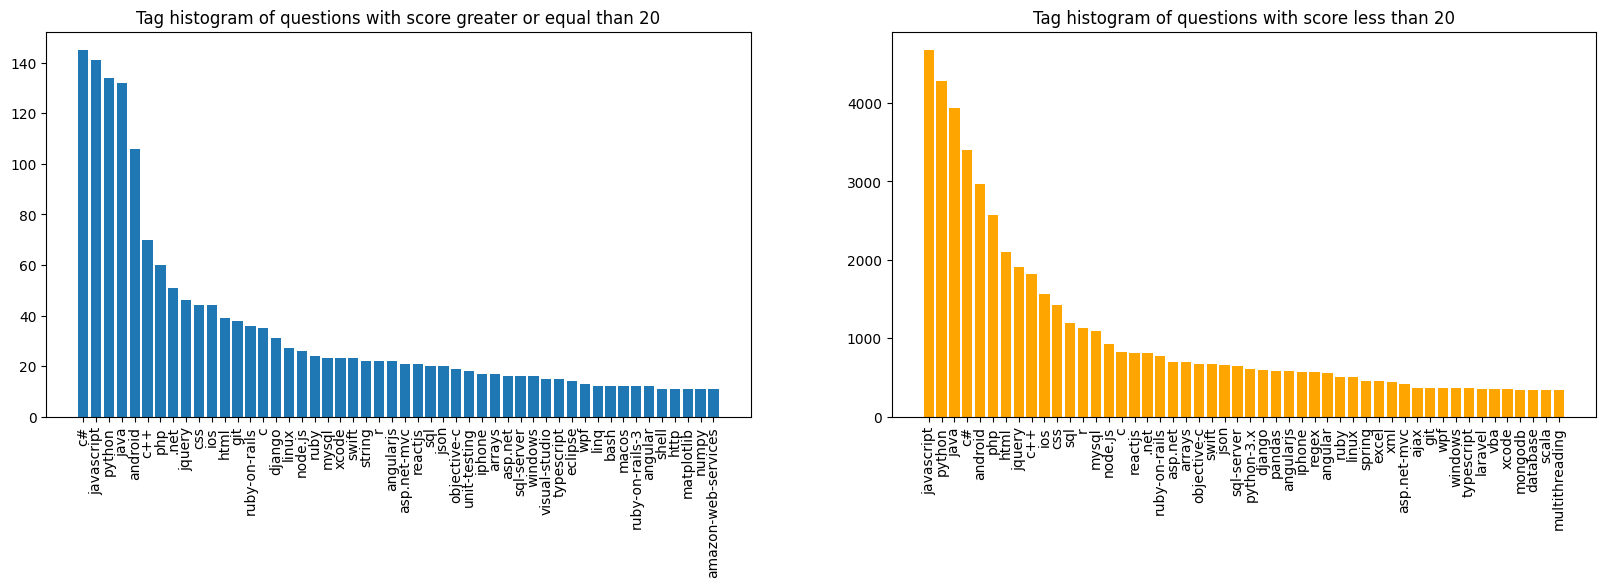

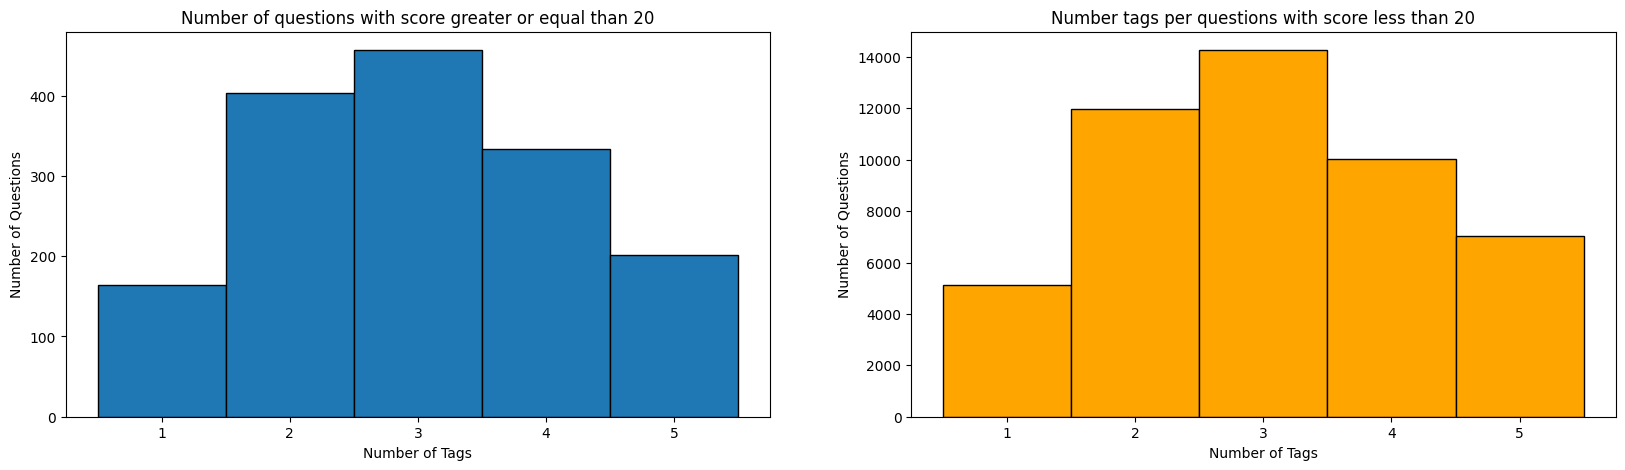

In [ ]:
score_threshold_tag_resutlts(20)

#### **Conclusion:**

We observe that separating our data according to score to higher values does  change the statistics of our subset at first glance.

From the analysis we can infer that questions with greater score tend to have slightly more tags than questions with less score, this could be interesting for our training dataset because it contains more information for the learning process that helps fulfill the actual purpose of a tag of being found. This assumes that high rated questions tend to have good tagging.

Given that we can find in our full dataset the questions with enough rating to train and evaluate, choosing a higher ratio of score seem to be preferable when compared to comparing with low scored questions, which may have the bad score because their title or text is non informative.

From this, we conclude that it is preferable to use higher rated scores and select the threshold at 20 in the training notebooks. To achieve this we simply set it as a condition in our SQL script.

## 2. Title analysis

The titles of questions seem to be a good place to analyse the feseability of a applying different algorithms to our problem.


### 2.1 Word cloud of titles

Word clouds are a good and informative way of visually observing raw available text data to

  0%|          | 0/50000 [00:00<?, ?it/s]

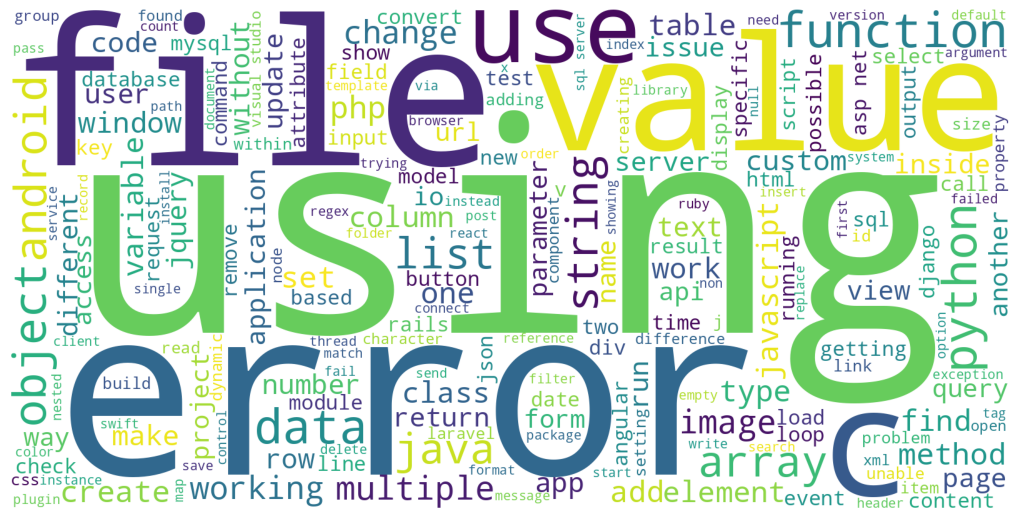

In [ ]:
# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm # loading bar

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tqdm(df.Title[~df.Title.isnull()]):

  # typecaste each val to string
  val = str(val)

  # split the value
  tokens = val.split()

  # Converts each token into lowercase
  for i in range(len(tokens)):
      tokens[i] = tokens[i].lower()

  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (16, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## 3. Tokenization

Here we process the title into a bow representation. This allows for a more in depth analysis of our data such that we can process it into features that can be better dealt by machine learning algorithms.

In [ ]:
# Transform titles to list
df.Title.to_list()[:10]

['How do I make a menu that does not require the user to press [enter] to make a selection?',
 'Is it acceptable for invalid XHTML?',
 'Instrumenting a UI',
 'How do you measure SQL Fill Factor value',
 "In C++/Windows how do I get the network name of the computer I'm on?",
 'Replacement for for... if array iteration',
 'How do I change the title bar icon in Adobe AIR?',
 'Best TinyMce editor Image Manager / File upload for Asp.net Mvc',
 'Is Project Darkstar Realistic?',
 'Memory leaks in .NET']

### 3.1 Tokenization of Titles

First we will create a tokenization pipeline. This is very important because a bad tokenization creates a bottleneck for machine learning. Here we use the tokenizer nltk.

Please refer to nltk for documentation:
https://www.nltk.org/api/nltk.tokenize.html


In [ ]:
# download and import required packages
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk.stem as stemmer
from nltk.stem.porter import *
import nltk
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# instantiate stemmer that will be used along the processing pipeline
stemmer = PorterStemmer()

**Observation:** Since we use a out of the box tokenizer we can add our own rules to it. An example would be to add the token for C# (c sharp). Otherwise it would be removed by the tokenizer.

In [ ]:
# add exceptions to tokenizer
tokenizer = nltk.tokenize.MWETokenizer()
tokenizer.add_mwe(('c#','c++', 'c', '#'))

Here we define the preprocessing we will apply to text.

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def initial_preprocess(text):
    if type(text) == str:
        return "".join([char for char in text if char not in '!"$%&\'()*,./:;<=>?@[\\]^_`{|}~']).lower()
    elif type(text) == float:
        # Convert float to string and apply punctuation removal and lowercasing
        string_text = str(text)
        return "".join([char for char in string_text if char not in '!"$%&\'()*,./:;<=>?@[\\]^_`{|}~']).lower()
    else:
        raise TypeError("Input to initial_preprocess must be a string or a float")

def preprocess(text):
    result = []
    # remove ponctuation but keep relevant data
    tokens = tokenizer.tokenize(word_tokenize(initial_preprocess(text)))
    for token in tokens:
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

### 3.2 Veryfing the tokenization on tags

We want our tokenizer to maintain all the tags intact or at least most of them intact. Here we verify if this is the case.

First let's see what tags are eliminated and divided by the tokenization

In [ ]:
df_tags['tokenized'] = df_tags.TagName.apply(preprocess)

In [ ]:
df_tags.head()

,Id,TagName,Count,tokenized
0,3,javascript,2387264,[javascript]
1,16,python,1968760,[python]
2,17,java,1850627,[java]
3,9,c#,1543059,[c_#]
4,5,php,1438539,[php]


We will observe which tags were mapped to wich token to check if one ground truth token has one or more tags. We create thus a dict of the tagname to the tokenized tag.

In [ ]:
# get an array with tokenized tags
tokenized_tags = df_tags.tokenized.to_numpy()

# get an array with the tag count
full_tag_count = (df_tags.Count).to_numpy()

First, tags could have been separated or eliminated. We need also to check this case!

In [ ]:
# count number of total tags
total = sum(full_tag_count)
# initialize the
n_lost = 0

# we will capture index of divided or lost tags
eliminated_tags = []
divided_tags = []

for idx, tag in enumerate(full_tags_array):
 tokenized_tag = preprocess(tag)
 # check if tag was mapped to zero
 if len(tokenized_tag) == 0:
   eliminated_tags.append(idx)
   n_lost += full_tag_count[idx]/total*100
   print("The tag '{}' ({:.2f}% of tags) was eliminated by tokenization".format(full_tags_array[idx], full_tag_count[idx]/total*100))

 #check if tags was divided
 if len(tokenized_tag) > 1:
   n_lost += full_tag_count[idx]/total*100
   print("The tag '{}' ({:.2f}% of tags) was divided by tokenization into '{}'".format(full_tags_array[idx], full_tag_count[idx]/total*100, tokenized_tag))
   divided_tags.append(idx)

print('\nTotal ammount of lost tags for tokenization: {:.2f}%'.format(n_lost))

The tag 'go' (0.09% of tags) was eliminated by tokenization
The tag 'c#-4.0' (0.04% of tags) was divided by tokenization into '['c_#', '-40']'
The tag 'get' (0.02% of tags) was eliminated by tokenization
The tag 'f#' (0.02% of tags) was divided by tokenization into '['f', '#']'
The tag 'find' (0.02% of tags) was eliminated by tokenization
The tag 'less' (0.01% of tags) was eliminated by tokenization
The tag 'this' (0.01% of tags) was eliminated by tokenization
The tag 'system' (0.01% of tags) was eliminated by tokenization
The tag 'call' (0.01% of tags) was eliminated by tokenization
The tag 'each' (0.01% of tags) was eliminated by tokenization
The tag 'where' (0.01% of tags) was eliminated by tokenization
The tag 'c#-3.0' (0.01% of tags) was divided by tokenization into '['c_#', '-30']'
The tag 'move' (0.00% of tags) was eliminated by tokenization
The tag 'show' (0.00% of tags) was eliminated by tokenization
The tag 'put' (0.00% of tags) was eliminated by tokenization
The tag 'faceboo

The total amount of tags lost is very close to zero.

In [ ]:
def select_first(token_list):
  return [token_list[0]]

df_tags.loc[divided_tags, 'tokenized'] = df_tags.loc[divided_tags, 'tokenized'].apply(select_first)

In [ ]:
df_tags.iloc[np.concatenate((np.arange(4),np.array(divided_tags[:4])))]


,Id,TagName,Count,tokenized
0,3,javascript,2387264,[javascript]
1,16,python,1968760,[python]
2,17,java,1850627,[java]
3,9,c#,1543059,[c_#]
326,64139,c#-4.0,25800,[c_#]
527,1198,f#,16417,[f]
1917,64136,c#-3.0,3679,[c_#]
3462,63311,facebook-c#-sdk,1796,[facebook-c]


Now we will create a dictionary to obtain the token given the tag. Note that one Token may correspond to more than one tag name. In a first approach we will use the one that is more frequent. In this case, the c#-4.0 tags will get mapped to c#, wich is a reasonable assumption.

In [ ]:
token2tag_dict = {}
for tag, token in zip(df_tags.TagName.to_numpy(), df_tags.tokenized.to_numpy()):
  # token should be a list containing only one element
  if len(token) == 0:
    print('passed {} because the token is null'.format(tag))
  elif token[0] in token2tag_dict.keys():
    #pass
    print('passed {} because the token has already been mapped to {}'.format(tag, token))
  else:
    token2tag_dict[token[0]] = tag

passed go because the token is null
passed c#-4.0 because the token has already been mapped to ['c_#']
passed https because the token has already been mapped to ['http']
passed datatables because the token has already been mapped to ['datat']
passed io because the token has already been mapped to ['io']
passed get because the token is null
passed routing because the token has already been mapped to ['rout']
passed data.table because the token has already been mapped to ['datat']
passed format because the token has already been mapped to ['format']
passed find because the token is null
passed iteration because the token has already been mapped to ['iter']
passed window because the token has already been mapped to ['window']
passed mapping because the token has already been mapped to ['map']
passed map because the token has already been mapped to ['map']
passed controls because the token has already been mapped to ['control']
passed expression because the token has already been mapped to

And now we have a dictionary that can be used to better evaluate the results of our models!

In [ ]:
token2tag_dict['javascript']

'javascript'

In [ ]:
token2tag_dict['c_#']

'c#'

### 3.2 Applying the tokenization

Now that we have analysed the tokenization method we tokenize the titles

In [ ]:
processed_titles = df.Title.map(preprocess)

Below we observe that the result of the tokenization.

In [ ]:
processed_titles

0               [menu, requir, user, press, enter, select]
1                                 [accept, invalid, xhtml]
2                                         [instrument, ui]
3                              [measur, sql, factor, valu]
4                                 [c++window, network, im]
                               ...                        
49995                                     [array, element]
49996    [cefsharp, winform, 101, read, cooki, browser,...
49997                        [line, line, text, csv, file]
49998    [execut, predefin, docker, command, java, appl...
49999                    [sql, count, instanc, occurr, id]
Name: Title, Length: 50000, dtype: object

Now we generate a corpora dictionary using the tokenized sentences. We will print the first 10 words from the dictionary.

In [ ]:
# Generate corpora dictionary
title_dictionary = gensim.corpora.Dictionary(processed_titles)

Print the first 10 entries

In [ ]:
print('there are {} entries on the corpora dict.\nFirst 10 entries:'.format(len(title_dictionary)))
print(list(title_dictionary.values())[:10])

there are 25575 entries on the corpora dict.
First 10 entries:
['enter', 'menu', 'press', 'requir', 'select', 'user', 'accept', 'invalid', 'xhtml', 'instrument']


To reduce the computational complexity we filter out words that appear less than a fixed number of times. The documentation gives the following parameters:

* no_below (int, optional) – Keep tokens which are contained in at least no_below documents.

* no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

* keep_n (int, optional) – Keep only the first keep_n most frequent tokens.

* keep_tokens (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

We observe a great reduction in the number of the dictionary entries. This will greatly accelerate computations.

In [ ]:
title_dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=10000)
print('After filtering there are {} entries on the corpora dict.\nFirst 10 entries:'.format(len(title_dictionary)))
print(list(title_dictionary.values())[:10])

After filtering there are 1981 entries on the corpora dict.
First 10 entries:
['enter', 'menu', 'press', 'requir', 'select', 'user', 'accept', 'invalid', 'instrument', 'ui']


With the dictionary in hands we can now create a BoW representation of titles.

In [ ]:
# create bow of title filtered corpus
title_bow_corpus = [title_dictionary.doc2bow(title) for title in processed_titles]

We can now observe the result of the preprocessing on a string of text

In [ ]:
# observe pre processing result on a sampling of the dataset
def sample_nlp_pipeline(sample_idx):
  print('sample idx:', sample_idx)

  print('saple tags:', df.Tags.to_list()[sample_idx])
  print('\nprocessing pipeline: \n')
  print('sample title:', df.Title.to_list()[sample_idx])
  print('preprocessed title:', processed_titles[sample_idx])
  print('bow_corpus of title:', title_bow_corpus[sample_idx])
  print('\nbag of words equivalence: ')
  bow_doc_sample = title_bow_corpus[sample_idx]
  for i in range(len(bow_doc_sample)):
      print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0],
                                                title_dictionary[bow_doc_sample[i][0]], bow_doc_sample[i][1]))


Let's observe the result on a random question

In [ ]:
# test preprocessing on a random question
sample_nlp_pipeline(np.random.randint(len(df.Tags)))

sample idx: 48559
saple tags: ['linux', 'bash']

processing pipeline: 

sample title: Linux - troubleshooting the "too many open files" error
preprocessed title: ['linux', '-', 'troubleshoot', 'open', 'file', 'error']
bow_corpus of title: [(27, 1), (102, 1), (125, 1), (267, 1), (412, 1)]

bag of words equivalence: 
Word 27 ("file") appears 1 time.
Word 102 ("-") appears 1 time.
Word 125 ("linux") appears 1 time.
Word 267 ("error") appears 1 time.
Word 412 ("open") appears 1 time.


In [ ]:
df.Title.to_list()[:10]

['How do I make a menu that does not require the user to press [enter] to make a selection?',
 'Is it acceptable for invalid XHTML?',
 'Instrumenting a UI',
 'How do you measure SQL Fill Factor value',
 "In C++/Windows how do I get the network name of the computer I'm on?",
 'Replacement for for... if array iteration',
 'How do I change the title bar icon in Adobe AIR?',
 'Best TinyMce editor Image Manager / File upload for Asp.net Mvc',
 'Is Project Darkstar Realistic?',
 'Memory leaks in .NET']

### **3.4 Tokenizing the Body**

Here we process the body of questions into a bow representation. Applying the same pipeline that we used for the Title is not straightforward since the text contains different sentences. Processing the body to alter tags would surely deliver better results and we leave it as a next step.

In [ ]:
df.Body.to_list()[:5]

['<p>I\'ve got a menu in Python. That part was easy. I\'m using <code>raw_input()</code> to get the selection from the user. </p>\n\n<p>The problem is that <code>raw_input</code> (and input) require the user to press <kbd>Enter</kbd> after they make a selection. Is there any way to make the program act immediately upon a keystroke? Here\'s what I\'ve got so far:</p>\n\n<pre><code>import sys\nprint """Menu\n1) Say Foo\n2) Say Bar"""\nanswer = raw_input("Make a selection&gt; ")\n\nif "1" in answer: print "foo"\nelif "2" in answer: print "bar"\n</code></pre>\n\n<p>It would be great to have something like</p>\n\n<pre><code>print menu\nwhile lastKey = "":\n    lastKey = check_for_recent_keystrokes()\nif "1" in lastKey: #do stuff...\n</code></pre>\n',
 "<p>I've noticed a lot of sites, SO included, use XHTML as their mark-up language and then fail to adhere to the spec. Just browsing the source for SO there are missing closing tags for paragraphs, invalid elements, etc.</p>\n\n<p>So should to

**Observation:** The preprocessing of the body may take a long time...

In [ ]:
processed_bodies = df.Body.map(preprocess)

In [ ]:
processed_bodies[:5]

0    [pive, get, menu, python, easi, im, coderawinp...
1    [pive, notic, lot, sit, includ, use, xhtml, ma...
2    [phow, instrument, ui, past, ive, read, peopl,...
3    [pusual, im, creat, index, tabl, gener, guess,...
4    [pin, c++, window, xp, nt, make, differ, appli...
Name: Body, dtype: object

In [ ]:
body_dictionary = gensim.corpora.Dictionary(processed_bodies)
count = 0
for k, v in body_dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 #
1 1
2 2
3 act
4 answer
5 bar
6 checkforrecentkeystrok
7 codepr
8 coderawinputcod
9 easi
10 elif


In [ ]:
body_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
body_bow_corpus = [body_dictionary.doc2bow(body) for body in processed_bodies]

In [ ]:
def sample_nlp_pipeline_body(sample_idx):
  print('sample idx:', sample_idx)

  print('saple tags:', df.Tags.to_list()[sample_idx])
  print('\nprocessing pipeline: \n')
  print('sample title:', df.Body.to_list()[sample_idx])
  print('preprocessed title:', processed_bodies[sample_idx])
  print('bow_corpus of body:', body_bow_corpus[sample_idx])
  print('bag of words equivalence: \n')
  bow_doc_sample = body_bow_corpus[sample_idx]
  for i in range(len(bow_doc_sample)):
      print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0],
                                                body_dictionary[bow_doc_sample[i][0]], bow_doc_sample[i][1]))


Restricting the number of words on the dictionary allows for more efficient calculations. We verify that tags are contained on it such that we will use the same pipeline as the one used to process the titles for the sake of simplicity.

In [ ]:
sample_nlp_pipeline_body(1)

sample idx: 1
saple tags: ['xhtml', 'markup']

processing pipeline: 

sample title: <p>I've noticed a lot of sites, SO included, use XHTML as their mark-up language and then fail to adhere to the spec. Just browsing the source for SO there are missing closing tags for paragraphs, invalid elements, etc.</p>

<p>So should tools (and developers) use the XHTML doctype if they are going to produce invalid mark up? And should browsers be more firm in their acceptance of poor mark-up?</p>

<p>And before anyone shouts hypocrite, my blog has one piece of invalid mark-up involving the captha (or it did the last time I checked) which involves styling the noscript tag.</p>

preprocessed title: ['pive', 'notic', 'lot', 'sit', 'includ', 'use', 'xhtml', 'mark-up', 'languag', 'fail', 'adher', 'spec', 'brows', 'sourc', 'miss', 'close', 'tag', 'paragraph', 'invalid', 'element', 'etcp', 'pso', 'tool', 'develop', 'use', 'xhtml', 'doctyp', 'go', 'produc', 'invalid', 'mark', 'browser', 'firm', 'accept', 'po

Finally, we test the same dictionary used for the title. Since the corpus used to create the corpus we will use each corpus separatedly.

In [ ]:
def sample_nlp_pipeline_body(sample_idx):
  print('sample idx:', sample_idx)

  print('sample tags:', df.Tags.to_list()[sample_idx])
  print('\nprocessing pipeline: \n')
  print('sample title:', df.Body.to_list()[sample_idx])
  print('preprocessed title:', processed_bodies[sample_idx])
  print('bow_corpus of body:', title_bow_corpus[sample_idx])
  print('bag of words equivalence: \n')
  bow_doc_sample = title_bow_corpus[sample_idx]
  for i in range(len(bow_doc_sample)):
      print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0],
                                                body_dictionary[bow_doc_sample[i][0]], bow_doc_sample[i][1]))

In [ ]:
sample_nlp_pipeline_body(1)

sample idx: 1
sample tags: ['xhtml', 'markup']

processing pipeline: 

sample title: <p>I've noticed a lot of sites, SO included, use XHTML as their mark-up language and then fail to adhere to the spec. Just browsing the source for SO there are missing closing tags for paragraphs, invalid elements, etc.</p>

<p>So should tools (and developers) use the XHTML doctype if they are going to produce invalid mark up? And should browsers be more firm in their acceptance of poor mark-up?</p>

<p>And before anyone shouts hypocrite, my blog has one piece of invalid mark-up involving the captha (or it did the last time I checked) which involves styling the noscript tag.</p>

preprocessed title: ['pive', 'notic', 'lot', 'sit', 'includ', 'use', 'xhtml', 'mark-up', 'languag', 'fail', 'adher', 'spec', 'brows', 'sourc', 'miss', 'close', 'tag', 'paragraph', 'invalid', 'element', 'etcp', 'pso', 'tool', 'develop', 'use', 'xhtml', 'doctyp', 'go', 'produc', 'invalid', 'mark', 'browser', 'firm', 'accept', 'p

# Notebook Conclusion:

We have sufficient evidence that we can indeed apply a machine learning algorithm on the processed titles and bodies to achieve a tag suggestion.

